In [11]:
import cv2
import numpy as np
import os
import tifffile as tiff
from matplotlib import pyplot as plt

In [23]:
# Load two TIFF images
def load_images(image1_path, image2_path):
    img1 = tiff.imread(image1_path)
    img2 = tiff.TiffFile(image2_path)
    img1_gray = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2_gray = img2.pages[0].asarray().squeeze()
    # Invert image, very important step, as MxIF is dark field image, while H&E is bright field image
    # Alignment will fail if there is no inversion
    img2_gray = cv2.bitwise_not(img2_gray) 
    return img1_gray, img2_gray

# Apply SIFT feature detection and alignment
def sift_alignment(img1, img2):
    sift = cv2.SIFT_create()
    keypoints1, descriptors1 = sift.detectAndCompute(img1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(img2, None)
    
    # Use FLANN-based matcher
    index_params = dict(algorithm=1, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    matches = flann.knnMatch(descriptors1, descriptors2, k=2)
    
    # Apply ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.75 * n.distance:
            good_matches.append(m)
    
    # Extract matched keypoints
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    
    # Compute homography matrix
    matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    
    # Warp image
    aligned_img = cv2.warpPerspective(img1, matrix, (img2.shape[1], img2.shape[0]))
    return aligned_img, good_matches, keypoints1, keypoints2, matrix

# 

In [24]:
data_dir = "/Users/jjiang10/Data/OV_TMA"

image1_path = os.path.join(data_dir, 'HE_H-13.tif')
image2_path = os.path.join(data_dir, 'MxIF_H-13.ome.tif')


In [25]:
img1, img2 = load_images(image1_path, image2_path)
aligned_img, good_matches, keypoints1, keypoints2, matrix = sift_alignment(img1, img2)

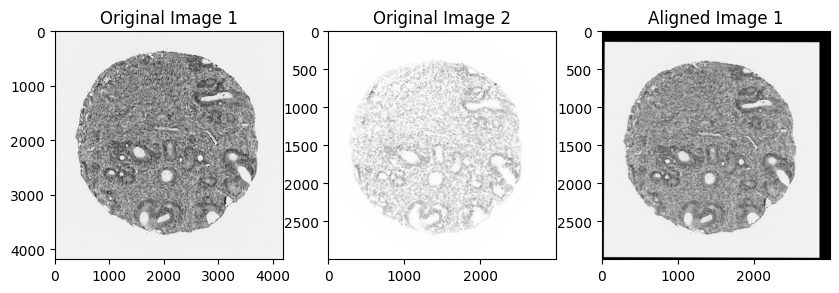

In [28]:
# Plot results
plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.title("Original Image 1")
plt.imshow(img1, cmap='gray')
# plt.plot([keypoint.pt[0] for keypoint in keypoints1], [keypoint.pt[1] for keypoint in keypoints1], 'ro')
plt.subplot(1, 3, 2)
plt.title("Original Image 2")
plt.imshow(img2, cmap='gray')
# plt.plot([keypoint.pt[0] for keypoint in keypoints2], [keypoint.pt[1] for keypoint in keypoints2], 'bo')
plt.subplot(1, 3, 3)
plt.title("Aligned Image 1")
plt.imshow(aligned_img, cmap='gray')
# plt.axis('off')
plt.show()

In [ ]:
# TODO: quantitatively evaluate the alignment results
# 1. calculate delta theta and delta translation based on the homography matrix.
# 2. Apply the homography matrix to the manually labeled landmarks of image 1, and compare with the landmarks of image 2, calculate delta distance.